In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import ast

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_all = pd.read_csv("/content/drive/MyDrive/Spotify/data.csv")
df_w_genres = pd.read_csv("/content/drive/MyDrive/Spotify/data_w_genres.csv")
df_by_artist = pd.read_csv("/content/drive/MyDrive/Spotify/data_by_artist.csv")
df_by_year = pd.read_csv("/content/drive/MyDrive/Spotify/data_by_year.csv")
df_by_genres = pd.read_csv("/content/drive/MyDrive/Spotify/data_by_genres.csv")

## Exploratory Data Analysis

### Understanding the different variables

This dataset does not come with an accompanying codebook that describes each column, so we must familiarize ourself with the data first and understand what each column represents for the different dataframes.

First, we will check the shape of our data.



In [4]:
print(df_all.shape)
print(df_w_genres.shape)
print(df_by_artist.shape)
print(df_by_year.shape)
print(df_by_genres.shape)

(170653, 19)
(28680, 16)
(28680, 15)
(100, 14)
(2973, 14)


Notice that `df_w_genres` and `df_by_artist` have the same number of rows, with `df_w_genres` having one more column. `df_all` has the most rows, so let's assume that this dataframe contains each song individually, while the other dataframes are aggregated datasets based on `df_all`.

`df_by_year` contains the average song characteristics by year for the past 100 years, and `df_by_genres` contains the average song characteristics per genre. Because this dataframe has 2973 rows, let's assume that there are 2973 different genres in this dataset.

We can now explore the different variables in each of the dataframes, as well as the values for each of the variables.

In [ ]:
df_all.dtypes

`artists`, `id`, `name`, and `release_date` are string values. `release_date` being a string doesn't make sense, so let's find out why the data type for this column is object (pandas stores strings as objects)

In [ ]:
df_all['release_date'].unique()

It seems like the values are a mix of full date strings and strings with just the year. Because there is already a year column, there may be no need for this column, as it is unlikely the exact day that a song is released is a useful feature when recommending a song. Let's remove it and keep exploring.

In [ ]:
df_all.drop('release_date', axis=1, inplace=True)
df_all.shape

(170653, 18)

In [ ]:
df_all.describe()

valence           year   acousticness   danceability  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        0.528587    1976.787241       0.502115       0.537396   
std         0.263171      25.917853       0.376032       0.176138   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.317000    1956.000000       0.102000       0.415000   
50%         0.540000    1977.000000       0.516000       0.548000   
75%         0.747000    1999.000000       0.893000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.706530e+05  170653.000000  170653.000000     170653.000000   
mean   2.309483e+05       0.482389       0.084575          0.167010   
std    1.261184e+05       0.267646       0.278249          0.313475   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.698270e+05       0.255000       0.000000          0.000000   
50%    2.074670e+05       0.471000       0.000000          0.000216   
75%    2.624000e+05       0.703000       0.000000          0.102000   
max    5.403500e+06       1.000000       1.000000          1.000000   

                 key       liveness       loudness           mode  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        5.199844       0.205839     -11.467990       0.706902   
std         3.515094       0.174805       5.697943       0.455184   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.098800     -14.615000       0.000000   
50%         5.000000       0.136000     -10.580000       1.000000   
75%         8.000000       0.261000      -7.183000       1.000000   
max        11.000000       1.000000       3.855000       1.000000   

          popularity    speechiness          tempo  
count  170653.000000  170653.000000  170653.000000  
mean       31.431794       0.098393     116.861590  
std        21.826615       0.162740      30.708533  
min         0.000000       0.000000       0.000000  
25%        11.000000       0.034900      93.421000  
50%        33.000000       0.045000     114.729000  
75%        48.000000       0.075600     135.537000  
max       100.000000       0.970000     243.507000

A lot of the variables have values ranging from 0 to 1. Some are because they are boolean encodings, such as `explicit` and `mode`, while others, such as `energy`, `instrumentalness`, `liveness`, etc., have values that are continuous from 0 to 1.

There are 12 different values for `key`, ranging from 0 to 11 which each represent the 12 different keys in western music theory.

The range of values for `loudness`, and `popularity` also seem to be bounded, but the ranges differ from the other features, so some normalization will probably have to be done to get them into the range of 0 to 1.

Some slightly concerning things that might need to be explored further is the fact that `loudness` ranges from very negative, **-60**, to slightly positive, **3.855**. The quartiles show that most of the songs have negative values for loudness, so there must be a reason why some songs have positive values. Another thing to explore is that fact that minimum value for `tempo` is 0, because, to my knowledge, no song should have a tempo of 0.

In [ ]:
df_w_genres.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [ ]:
df_w_genres.describe()

acousticness  danceability   duration_ms        energy  \
count  28680.000000  28680.000000  2.868000e+04  28680.000000   
mean       0.498373      0.546490  2.388780e+05      0.497488   
std        0.370614      0.176474  1.211318e+05      0.254885   
min        0.000000      0.000000  1.879550e+04      0.000000   
25%        0.122296      0.431000  1.823304e+05      0.283568   
50%        0.478458      0.557000  2.186400e+05      0.504000   
75%        0.896000      0.675000  2.684670e+05      0.702783   
max        0.996000      0.986000  5.403500e+06      1.000000   

       instrumentalness      liveness      loudness   speechiness  \
count      28680.000000  28680.000000  28680.000000  28680.000000   
mean           0.174756      0.202441    -11.140498      0.094014   
std            0.298406      0.140884      5.771749      0.111986   
min            0.000000      0.000000    -60.000000      0.000000   
25%            0.000004      0.110362    -13.972292      0.039200   
50%            0.001880      0.161000    -10.088938      0.052200   
75%            0.215291      0.247000     -6.889000      0.095300   
max            1.000000      0.991000      1.342000      0.964000   

              tempo       valence    popularity           key          mode  \
count  28680.000000  28680.000000  28680.000000  28680.000000  28680.000000   
mean     115.844830      0.512723     34.060945      5.412901      0.759170   
std       25.003834      0.244421     22.376438      3.480552      0.427595   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       99.366500      0.329000     12.000000      2.000000      1.000000   
50%      115.357400      0.523243     39.000000      6.000000      1.000000   
75%      129.848750      0.703000     51.000000      8.000000      1.000000   
max      217.743000      0.991000     93.000000     11.000000      1.000000   

              count  
count  28680.000000  
mean      13.847211  
std       53.372544  
min        1.000000  
25%        2.000000  
50%        3.000000  
75%        8.000000  
max     3169.000000

This dataframe has a subset of the columns from the `df_all` dataframe, and is the same as the `df_by_artist` dataframe, except it has an additional `genres` column. This dataframe also has an additional `count` column that isn't seen in the `df_all` dataframe. The meaning of the count column is unclear. There are probably two things that this can mean: number of songs in a users playlist, or number of songs by this artist in the `df_all` dataframe. I'm learning towards the second option, but let's double check.

In [ ]:
df_w_genres['count'].sum()

397138

In [ ]:
# Account for multiple artists being listed for one song
df_all['num_artists'] = df_all['artists'].apply(ast.literal_eval).apply(lambda x: len(x))

In [ ]:
df_all['num_artists'].sum()

226497

If the second case I stated above is true, then these values should be equal, but they aren't, therefore count cannot represent the number of songs by this artist in the `df_all` dataframe. Additionally, it is highly unlikely that the count refers to the number of songs by this artist in a user's playlist as it is hard to imagine a user would have more than a thousand songs in a playlist, let alone 226,497 songs.

*NOTE: I'm aware that the value includes redundant counts of an artists songs, but even without that the value is still too large to represent that number of songs in a user's playlist*

Because we cannot confirm the meaning of the `count` column, we will ignore it.

In [ ]:
df_by_year.dtypes

mode                  int64
year                  int64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object

In [ ]:
df_by_year.describe()

mode         year  acousticness  danceability    duration_ms  \
count  100.0   100.000000    100.000000    100.000000     100.000000   
mean     1.0  1970.500000      0.556317      0.536783  227296.752234   
std      0.0    29.011492      0.275358      0.052356   25630.048065   
min      1.0  1921.000000      0.219931      0.414445  156881.657475   
25%      1.0  1945.750000      0.289516      0.500800  210889.193536   
50%      1.0  1970.500000      0.459190      0.540976  235520.850833   
75%      1.0  1995.250000      0.856711      0.570948  247702.738058   
max      1.0  2020.000000      0.962607      0.692904  267677.823086   

           energy  instrumentalness    liveness    loudness  speechiness  \
count  100.000000        100.000000  100.000000  100.000000   100.000000   
mean     0.452705          0.193582    0.208224  -11.969054     0.105861   
std      0.161738          0.122488    0.017903    3.105610     0.082128   
min      0.207948          0.016376    0.168450  -19.275282     0.049098   
25%      0.280733          0.103323    0.197509  -14.189232     0.064244   
50%      0.495997          0.127644    0.206074  -11.773061     0.085763   
75%      0.598008          0.276707    0.218493   -9.950542     0.104438   
max      0.681778          0.581701    0.264335   -6.595067     0.490001   

            tempo     valence  popularity       key  
count  100.000000  100.000000  100.000000  100.0000  
mean   116.015674    0.532120   27.376065    3.7900  
std      5.669645    0.057809   20.703197    3.5627  
min    100.884521    0.379327    0.140845    0.0000  
25%    111.718626    0.497174    3.298200    0.0000  
50%    117.455548    0.541503   33.619250    2.0000  
75%    120.606644    0.570080   44.943375    7.0000  
max    124.283129    0.663725   65.256542   10.0000

In [ ]:
df_by_genres.dtypes

mode                  int64
genres               object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object

In [ ]:
df_by_genres.describe()

mode  acousticness  danceability   duration_ms       energy  \
count  2973.000000   2973.000000   2973.000000  2.973000e+03  2973.000000   
mean      0.833165      0.401241      0.537187  2.517209e+05     0.561143   
std       0.372891      0.319760      0.150668  9.465686e+04     0.234486   
min       0.000000      0.000003      0.056900  3.094600e+04     0.001002   
25%       1.000000      0.119050      0.441202  2.063788e+05     0.395058   
50%       1.000000      0.321745      0.546496  2.375453e+05     0.601195   
75%       1.000000      0.673991      0.647500  2.772720e+05     0.730127   
max       1.000000      0.996000      0.929000  2.382587e+06     0.994667   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       2973.000000  2973.000000  2973.000000  2973.000000  2973.000000   
mean           0.211366     0.192800   -10.509848     0.083588   119.018723   
std            0.267329     0.092356     5.369202     0.080483    17.469188   
min            0.000000     0.022200   -41.825000     0.023800    47.135722   
25%            0.004835     0.137687   -12.427656     0.044900   109.198143   
50%            0.080700     0.178764    -9.221817     0.059457   119.194167   
75%            0.343333     0.220856    -6.920125     0.091000   127.508750   
max            0.992000     0.960000     0.060000     0.946219   204.212000   

           valence   popularity          key  
count  2973.000000  2973.000000  2973.000000  
mean      0.492748    39.919185     5.938782  
std       0.201820    16.748723     3.368110  
min       0.003353     0.000000     0.000000  
25%       0.348578    32.491279     3.000000  
50%       0.500048    43.056569     7.000000  
75%       0.640257    51.138889     9.000000  
max       0.980000    80.666667    11.000000

### Data quality checking

Now that we have explored what each of the variables mean, as well as the values that each variable can be, let's make sure that our data is clean before we explore the relationships possible relationships within the data.

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  speechiness       17

In [ ]:
df_by_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              28680 non-null  int64  
 1   count             28680 non-null  int64  
 2   acousticness      28680 non-null  float64
 3   artists           28680 non-null  object 
 4   danceability      28680 non-null  float64
 5   duration_ms       28680 non-null  float64
 6   energy            28680 non-null  float64
 7   instrumentalness  28680 non-null  float64
 8   liveness          28680 non-null  float64
 9   loudness          28680 non-null  float64
 10  speechiness       28680 non-null  float64
 11  tempo             28680 non-null  float64
 12  valence           28680 non-null  float64
 13  popularity        28680 non-null  float64
 14  key               28680 non-null  int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 3.3+ MB


In [ ]:
df_by_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB


In [ ]:
df_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB


In [ ]:
df_w_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

Each of the columns in each of the dataframes have a non-null count equal to the number of rows in each dataframe, meaning no row contains null values.

There may be missing data in other forms, such as an empty list or string. Let's check to see if there are any empty lists in the `artists` or `genres` columns in the dataframes.

In [ ]:
# Convert list strings into list objects
df_all['artists'] = df_all['artists'].apply(ast.literal_eval)
# df_by_artist['artists'] = df_by_artist['artists'].apply(ast.literal_eval) # Ignore because one artist per row
# df_by_genres['genres'] = df_by_genres['genres'].apply(ast.literal_eval) # Ignore because one genre per row
# df_w_genres['artists'] = df_w_genres['artists'].apply(ast.literal_eval) # Ignore since this df is just df_by_artist with an extra column for genres
df_w_genres['genres'] = df_w_genres['genres'].apply(ast.literal_eval)

In [ ]:
df_all['artists'].apply(lambda x: len(x) == 0).sum()

0

In [ ]:
df_w_genres['genres'].apply(lambda x: len(x) == 0).sum()

9857

So it seems like there are entries with an empty array for the `genres` variable. Let's check if this empty array also shows up in `df_by_genres`. This dataframe does not list multiple genres in an array, so let's check this by either comparing the value to an empty string, or a string of an empty array.

In [ ]:
df_by_genres['genres'].apply(lambda x: x == '' or x == '[]').sum()

1

So although there are no null values in our data, we do have missing values only for the `genres` variable. The `genres` value cannot be directly imputed using basic methods like mean or median as the values are categorical. Later on, we could see if we can use clustering models or logistic regressions to impute values to rows without `genres` values.

After ensuring the quality of our data, we can now move on to some initial data analysis to see if there are any trends or insights we can gain from the data to help build our recommendation model.

### Univariate Analysis

We will now look at all the possible varibles to use and explore the distributions of their values.

#### Valence

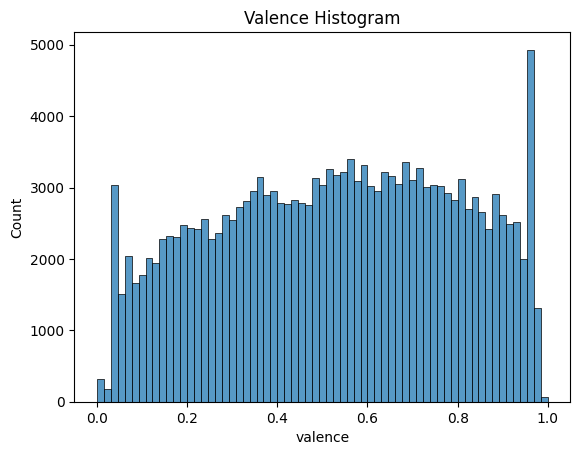

In [ ]:
sns.histplot(data=df_all, x='valence')
plt.title('Valence Histogram')
plt.show()

In [ ]:
df_all['valence'].skew()

-0.10711976001918852

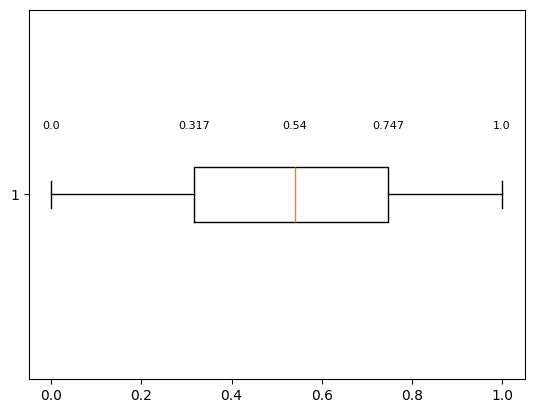

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='valence', vert=False)
box_data = df_all['valence']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['valence'] < lower_bound) | (df_all['valence'] > upper_bound)]
print(outliers.shape)
outliers.head()

(0, 19)


Empty DataFrame
Columns: [valence, year, acousticness, artists, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, speechiness, tempo, num_artists]
Index: []

Valence has a slight left skew, indicating a slight tendency towards a higher valence value. There are no outliers.

#### Acousticness

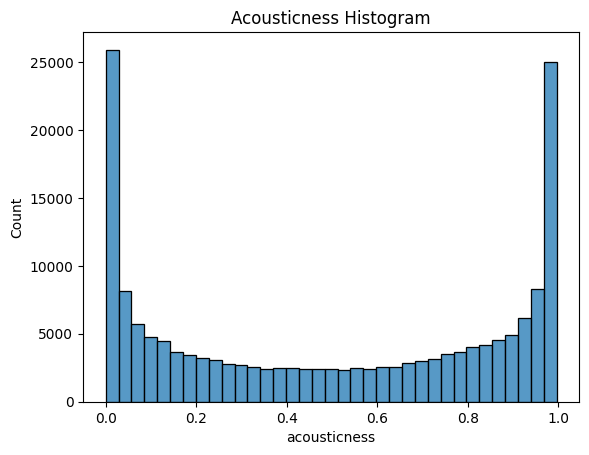

In [ ]:
sns.histplot(data=df_all, x='acousticness')
plt.title('Acousticness Histogram')
plt.show()

In [ ]:
df_all['acousticness'].skew()

-0.032582417993998435

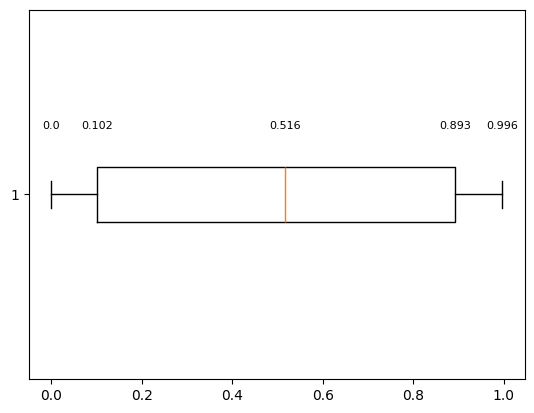

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='acousticness', vert=False)
box_data = df_all['acousticness']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['acousticness'] < lower_bound) | (df_all['acousticness'] > upper_bound)]
print(outliers.shape)
outliers.head()

(0, 19)


Empty DataFrame
Columns: [valence, year, acousticness, artists, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, speechiness, tempo, num_artists]
Index: []

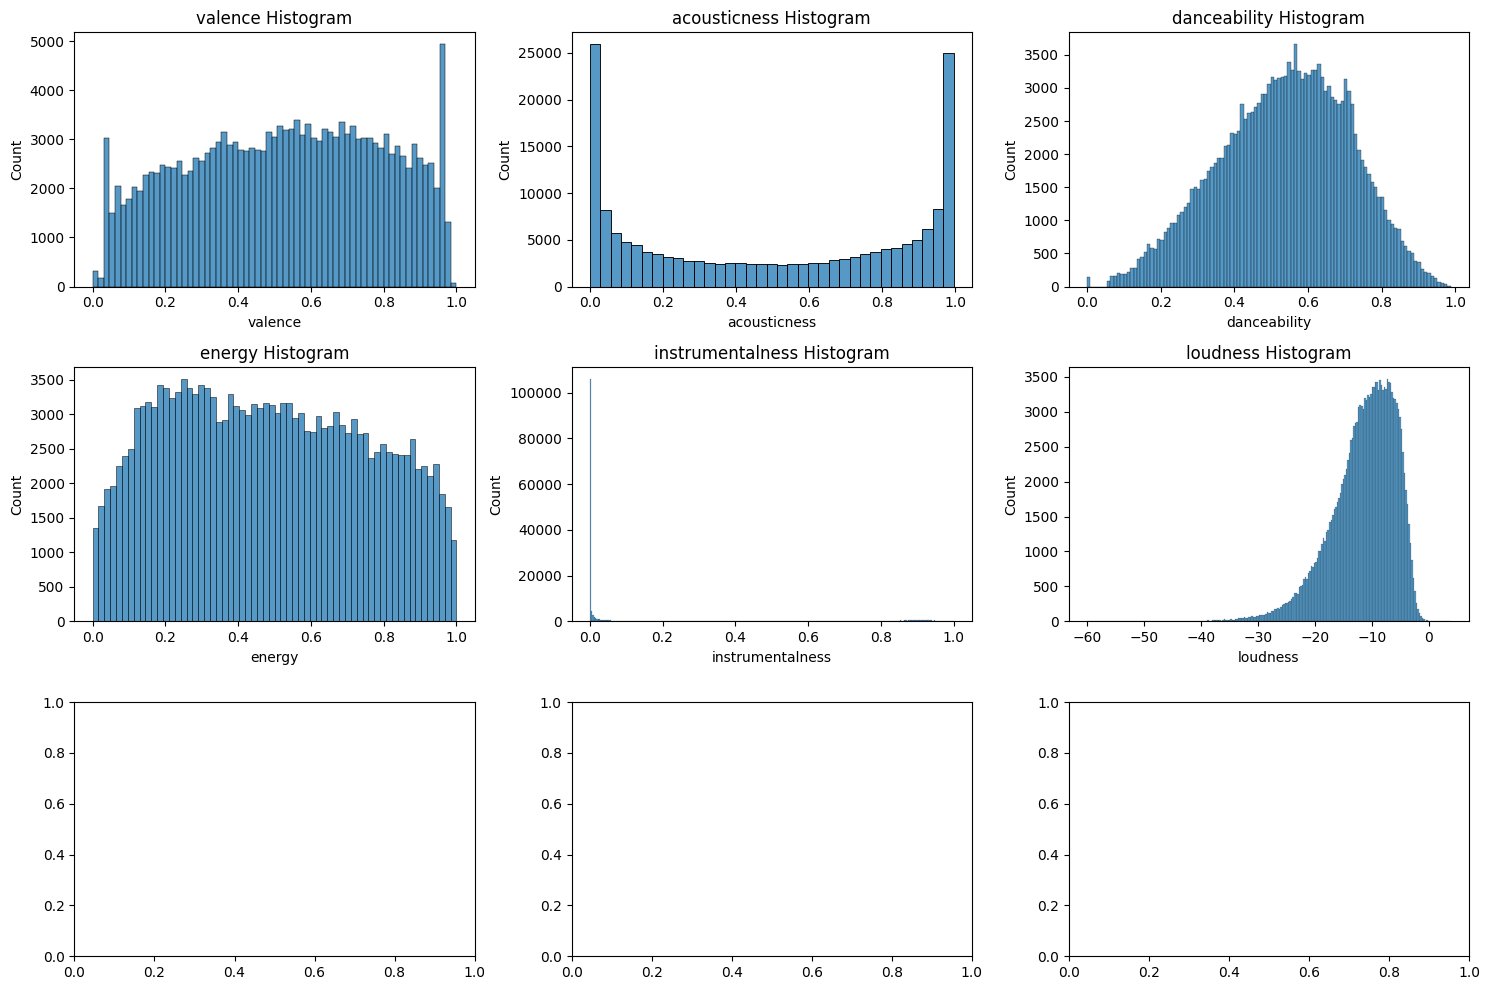

In [ ]:
features = ['valence', 'acousticness', 'danceability', 'energy',
            'instrumentalness', 'loudness']

# Create a figure and subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through features and plot histograms
for i, feature in enumerate(features):
    sns.histplot(data=df_all, x=feature, ax=axes[i])
    axes[i].set_title(f'{feature} Histogram')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Acousticness has a symmetrical distribution with high concentration on the high and low ends. There is basically no skew and no outliers.

#### Danceability

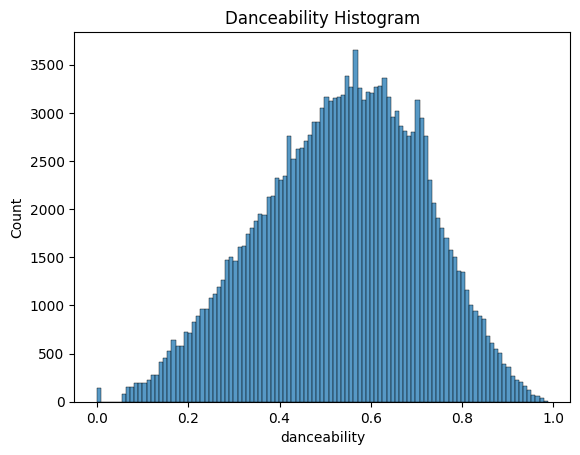

In [ ]:
sns.histplot(data=df_all, x='danceability')
plt.title('Danceability Histogram')
plt.show()

In [ ]:
df_all['danceability'].skew()

-0.22347134535177565

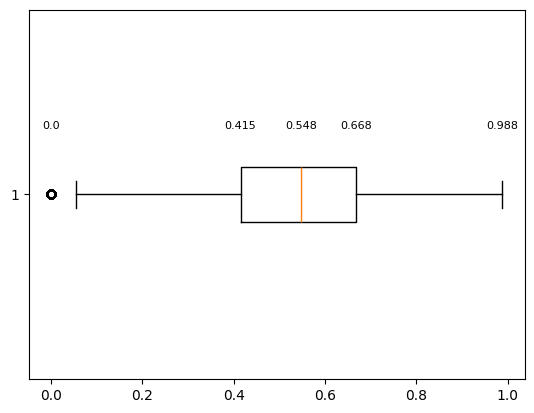

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='danceability', vert=False)
box_data = df_all['danceability']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['danceability'] < lower_bound) | (df_all['danceability'] > upper_bound)]
print(outliers.shape)
outliers.describe()

(143, 19)


valence         year  acousticness  danceability   duration_ms  \
count    143.0   143.000000    143.000000         143.0  1.430000e+02   
mean       0.0  1985.818182      0.560623           0.0  1.891800e+05   
std        0.0    33.743990      0.409229           0.0  4.577506e+05   
min        0.0  1924.000000      0.000000           0.0  5.108000e+03   
25%        0.0  1949.500000      0.117500           0.0  6.912900e+04   
50%        0.0  2009.000000      0.747000           0.0  1.435830e+05   
75%        0.0  2017.000000      0.951000           0.0  1.768465e+05   
max        0.0  2020.000000      0.996000           0.0  5.403500e+06   

           energy    explicit  instrumentalness         key    liveness  \
count  143.000000  143.000000        143.000000  143.000000  143.000000   
mean     0.186423    0.013986          0.481097    4.776224    0.307774   
std      0.263091    0.117845          0.417927    3.662562    0.268493   
min      0.000000    0.000000          0.000000    0.000000    0.000000   
25%      0.000062    0.000000          0.000809    1.000000    0.111000   
50%      0.040100    0.000000          0.399000    5.000000    0.182000   
75%      0.303000    0.000000          0.927000    8.000000    0.480500   
max      1.000000    1.000000          1.000000   11.000000    0.970000   

         loudness        mode  popularity  speechiness  tempo  num_artists  
count  143.000000  143.000000  143.000000        143.0  143.0   143.000000  
mean   -22.599427    0.713287   37.265734          0.0    0.0     1.671329  
std     13.449279    0.453816   28.585417          0.0    0.0     1.418074  
min    -60.000000    0.000000    0.000000          0.0    0.0     1.000000  
25%    -25.555500    0.000000    0.000000          0.0    0.0     1.000000  
50%    -19.082000    1.000000   48.000000          0.0    0.0     1.000000  
75%    -15.291000    1.000000   62.500000          0.0    0.0     1.000000  
max      3.855000    1.000000   85.000000          0.0    0.0     8.000000

Danceability has a slight left skew of -0.22, indicating favor towards sounds of higher danceability values. There are 143 outliers, all of which have danceability values of 0. There is a gap between the outliers and the minimum danceability value of the rest of the data. Instead of removing these songs, I will probably bin the data later on to include these songs with the rest of the low danceability songs.

#### Duration

<Axes: xlabel='duration_ms', ylabel='Count'>

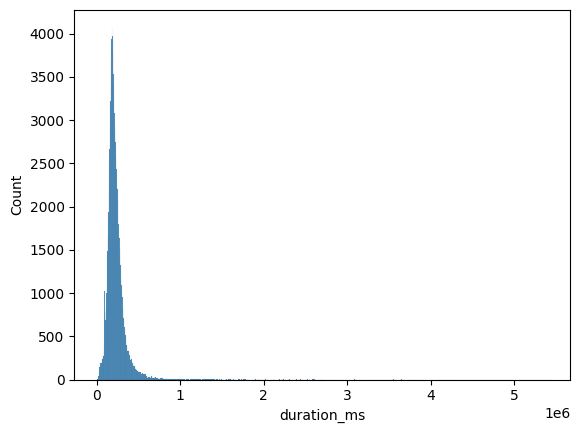

In [ ]:
sns.histplot(data=df_all, x='duration_ms')

In [ ]:
df_all['duration_ms'].skew()

7.313740721820854

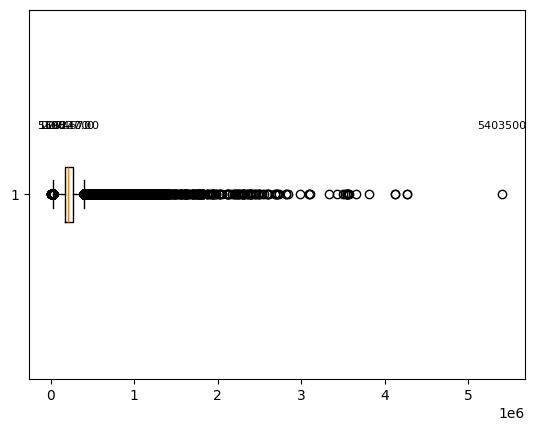

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='duration_ms', vert=False)
box_data = df_all['duration_ms']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['duration_ms'] < lower_bound) | (df_all['duration_ms'] > upper_bound)]
print(outliers.shape)
outliers.describe()

(9518, 19)


valence         year  acousticness  danceability   duration_ms  \
count  9518.000000  9518.000000   9518.000000   9518.000000  9.518000e+03   
mean      0.361349  1969.098550      0.579151      0.422774  5.653767e+05   
std       0.258620    22.218625      0.376886      0.185507  3.037338e+05   
min       0.000000  1921.000000      0.000000      0.000000  5.108000e+03   
25%       0.130000  1951.000000      0.168250      0.287000  4.326868e+05   
50%       0.317000  1969.000000      0.712000      0.404000  4.883400e+05   
75%       0.557000  1985.000000      0.942000      0.551000  5.917035e+05   
max       1.000000  2020.000000      0.996000      0.983000  5.403500e+06   

            energy     explicit  instrumentalness          key     liveness  \
count  9518.000000  9518.000000       9518.000000  9518.000000  9518.000000   
mean      0.406124     0.021958          0.361539     5.144463     0.244163   
std       0.268684     0.146555          0.378579     3.527409     0.236636   
min       0.000000     0.000000          0.000000     0.000000     0.000000   
25%       0.176000     0.000000          0.001170     2.000000     0.097200   
50%       0.360000     0.000000          0.173000     5.000000     0.133000   
75%       0.618000     0.000000          0.800000     8.000000     0.300000   
max       1.000000     1.000000          1.000000    11.000000     0.999000   

          loudness         mode   popularity  speechiness        tempo  \
count  9518.000000  9518.000000  9518.000000  9518.000000  9518.000000   
mean    -14.328439     0.650242    23.539084     0.092679   111.689282   
std       6.037073     0.476919    19.306101     0.171017    29.482779   
min     -60.000000     0.000000     0.000000     0.000000     0.000000   
25%     -17.941000     0.000000     1.000000     0.037500    88.653000   
50%     -13.729000     1.000000    25.000000     0.044300   110.413500   
75%      -9.838750     1.000000    39.000000     0.061500   131.153250   
max       0.674000     1.000000    81.000000     0.968000   217.591000   

       num_artists  
count  9518.000000  
mean      1.767493  
std       1.300757  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       2.000000  
max      22.000000

Don't wanna open this can of worms. I think I'll ignore this variable. Song duration is probably not an indicator of a songs vibe anyways, and all the other variables are actually telling of a songs mood.

#### Energy

<Axes: xlabel='energy', ylabel='Count'>

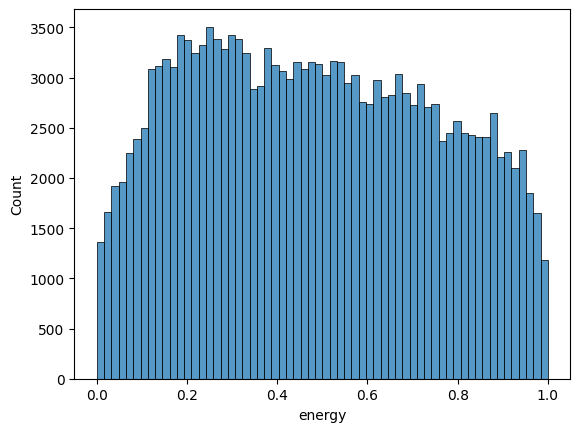

In [ ]:
sns.histplot(data=df_all, x='energy')




In [ ]:
df_all['energy'].skew()

0.11203494383922352

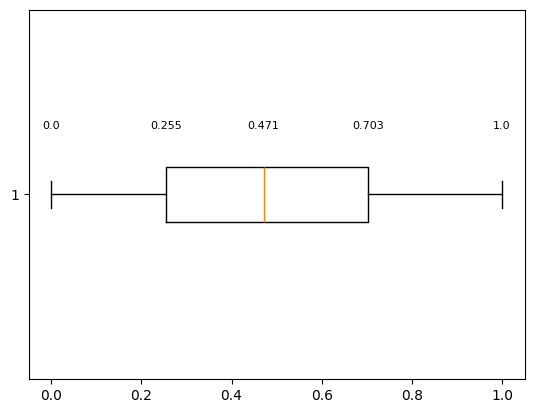

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='energy', vert=False)
box_data = df_all['energy']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['energy'] < lower_bound) | (df_all['energy'] > upper_bound)]
print(outliers.shape)
outliers.head()

(0, 19)


Empty DataFrame
Columns: [valence, year, acousticness, artists, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, speechiness, tempo, num_artists]
Index: []

Energy has a very slight right skew, so songs slightly tend towards the lower end. It would be interesting to compare the relationship between energy and danceability, as danceability has a slightly negative skew of -0.22, and in my head, danceability and energy are highly correlated. We can explore this later.

#### Instrumentalness

<Axes: xlabel='instrumentalness', ylabel='Count'>

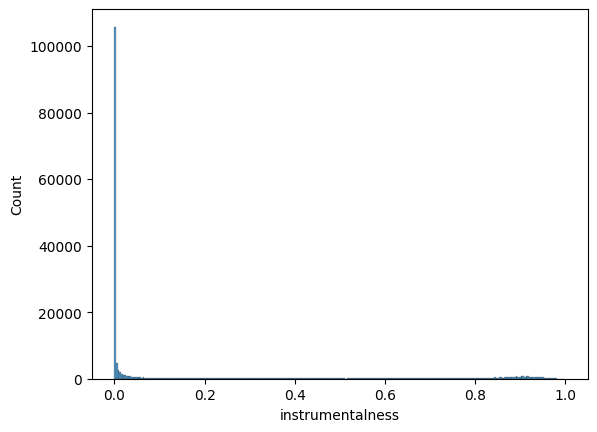

In [ ]:
sns.histplot(data=df_all, x='instrumentalness')


In [ ]:
df_all['instrumentalness'].skew()

1.6311140491429703

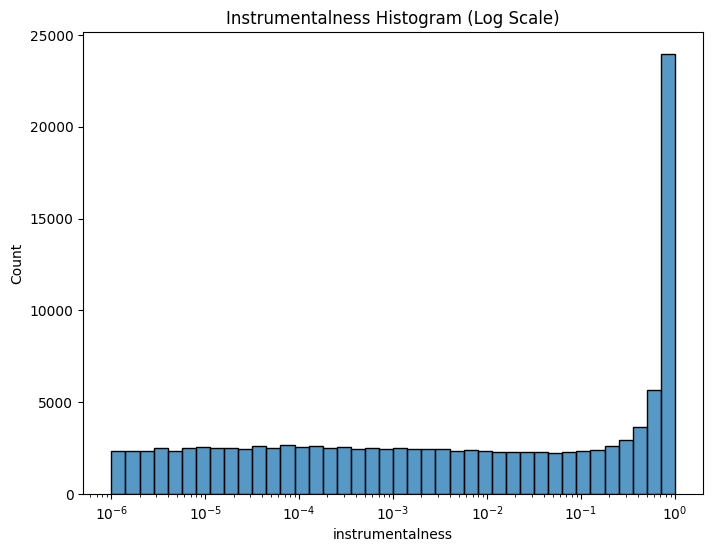

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_all, x='instrumentalness', log_scale=True)
plt.title('Instrumentalness Histogram (Log Scale)')
plt.show()

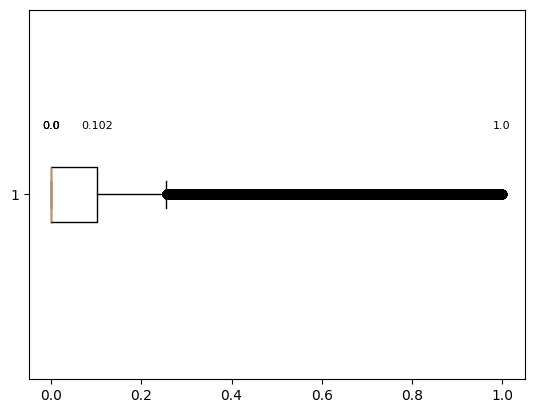

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='instrumentalness', vert=False)
box_data = df_all['instrumentalness']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['instrumentalness'] < lower_bound) | (df_all['instrumentalness'] > upper_bound)]
print(outliers.shape)
outliers.head()

(36105, 19)


valence  year  acousticness  \
0    0.0594  1921         0.982   
2    0.0394  1921         0.961   
7    0.0731  1921         0.993   
11   0.5780  1921         0.994   
13   0.2120  1921         0.912   

                                              artists  danceability  \
0   [Sergei Rachmaninoff, James Levine, Berliner P...         0.279   
2   [KHP Kridhamardawa Karaton Ngayogyakarta Hadin...         0.328   
7                               [Sergei Rachmaninoff]         0.389   
11                                  [Ignacio Corsini]         0.378   
13                                  [Mehmet Kemiksiz]         0.415   

    duration_ms  energy  explicit                      id  instrumentalness  \
0        831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz             0.878   
2        500062   0.166         0  1o6I8BglA6ylDMrIELygv1             0.913   
7        218773   0.088         0  02GDntOXexBFUvSgaXLPkd             0.527   
11       155413   0.115         0  0F30WM8qRpO8kdolepZqdM             0.906   
13       184973   0.420         0  0LcXzABeA84EgudqpNUN1I             0.890   

    key  liveness  loudness  mode  \
0    10     0.665   -20.096     1   
2     3     0.101   -14.850     1   
7     1     0.363   -21.091     0   
11   10     0.110   -27.039     0   
13    8     0.108   -10.766     0   

                                                 name  popularity  \
0   Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4   
2                                           Gati Bali           5   
7   Morceaux de fantaisie, Op. 3: No. 2, Prélude i...           2   
11                 Por Que Me Dejaste - Remasterizado           0   
13                                         Ud Taksimi           0   

    speechiness    tempo  num_artists  
0        0.0366   80.954            3  
2        0.0339  110.339            1  
7        0.0456   92.867            1  
11       0.0414   70.370            1  
13       0.1140   70.758            1

Instrumentalness is right skewed with a value of 1.63. We can see from the distribution that most songs cluster around the lowest instrumentalness score, with a somewhat even uniformly distributed above with a slight bump on the high end of instrumentalness. This could be binned as low, medium, and high, indicating the tradeoff between vocals and instrumentals in the song

#### Liveness

<Axes: xlabel='liveness', ylabel='Count'>

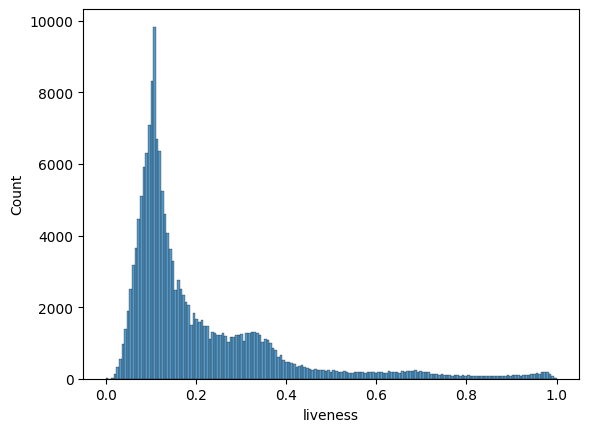

In [ ]:
sns.histplot(data=df_all, x='liveness')

In [ ]:
df_all['liveness'].skew()

2.154381536108022

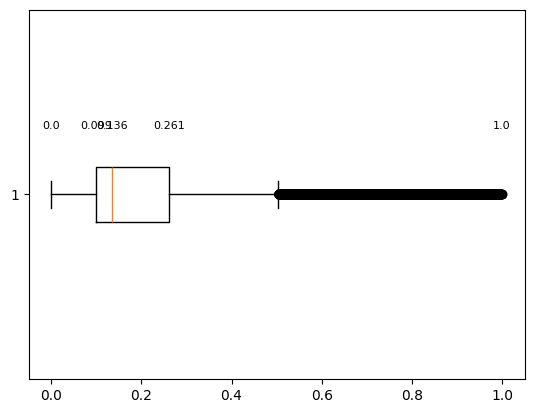

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='liveness', vert=False)
box_data = df_all['liveness']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['liveness'] < lower_bound) | (df_all['liveness'] > upper_bound)]
print(outliers.shape)
outliers['liveness'].head()

(11808, 19)


0      0.665
39     0.665
146    0.546
147    0.690
161    0.929
Name: liveness, dtype: float64

Because liveness gives a probability of whether or not a song is performed live, we will ignore it as a user is probably drawn towards a song for its artist, rather than the fact it is perfromed live.

#### Loudness

<Axes: xlabel='loudness', ylabel='Count'>

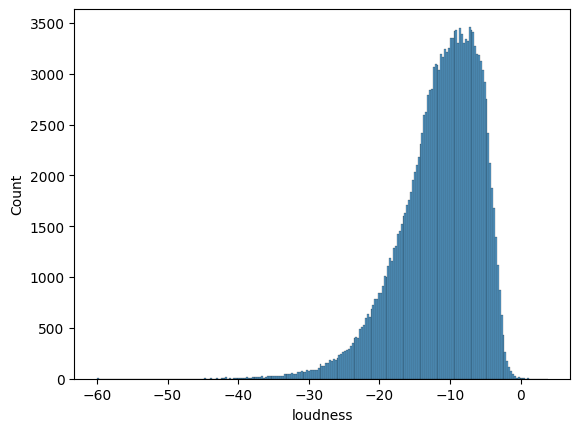

In [ ]:
sns.histplot(data=df_all, x='loudness')

In [ ]:
df_all['loudness'].skew()

-1.05184108770224

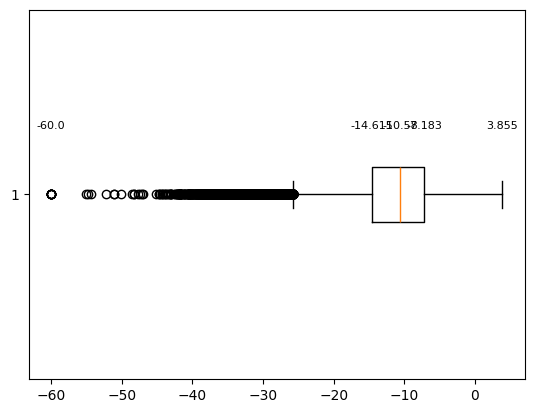

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='loudness', vert=False)
box_data = df_all['loudness']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['loudness'] < lower_bound) | (df_all['loudness'] > upper_bound)]
print(outliers.shape)
outliers['loudness'].describe()

(3501, 19)


count    3501.000000
mean      -29.961349
std         4.189679
min       -60.000000
25%       -31.679000
50%       -28.654000
75%       -26.977000
max       -25.763000
Name: loudness, dtype: float64

Loudness has a left skew of -1.05, indicating songs tend to be on the louder end. All songs with a loudness score of below -25 seem to be classified as outliers, but because there are 3501 of these songs, I will include them in a bin of "very low".

#### Popularity

<Axes: xlabel='popularity', ylabel='Count'>

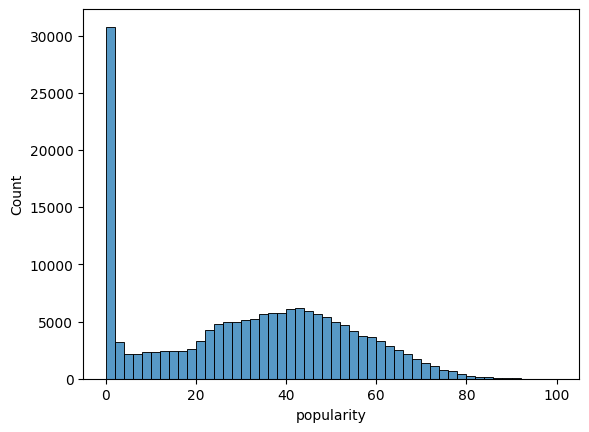

In [ ]:
sns.histplot(data=df_all, x='popularity', bins=50)

In [ ]:
df_all['popularity'].skew()

-0.0037338749990396785

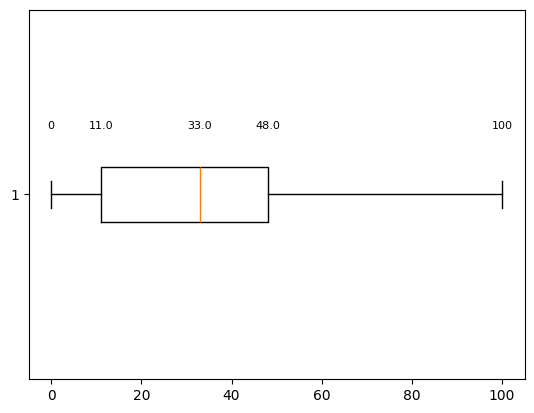

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='popularity', vert=False)
box_data = df_all['popularity']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['popularity'] < lower_bound) | (df_all['popularity'] > upper_bound)]
print(outliers.shape)
outliers.head()

(0, 19)


Empty DataFrame
Columns: [valence, year, acousticness, artists, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, speechiness, tempo, num_artists]
Index: []

Popularity has a slightly negative skew. Looking at the distribution plot, it is likely due to the large number of songs that have a very low popularity value. This makes sense, as most artists who put their music on spotify are likely not super famous. From experience, songs that have some form of traction are far more likely to be recommended than songs with 0 listeners.

#### Speechiness

<Axes: xlabel='speechiness', ylabel='Count'>

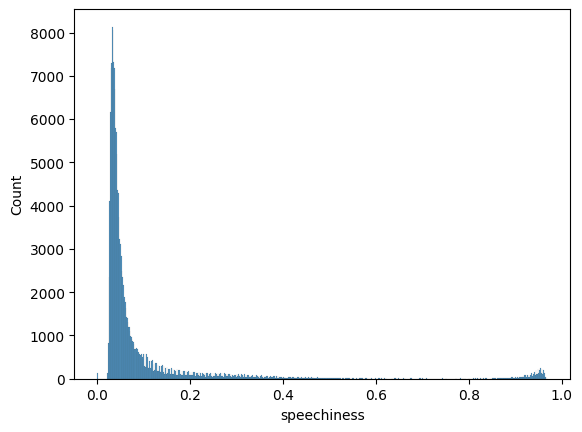

In [ ]:
sns.histplot(data=df_all, x='speechiness')

In [ ]:
df_all['speechiness'].skew()

4.047848460843855

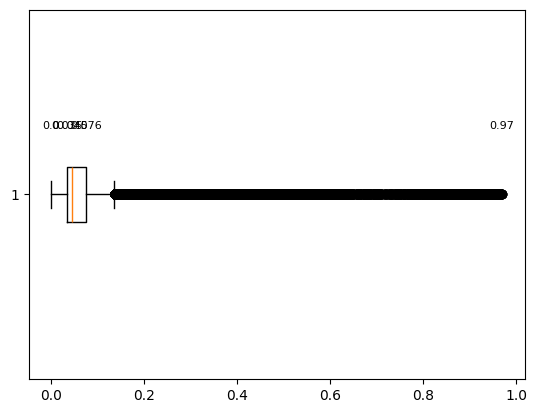

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='speechiness', vert=False)
box_data = df_all['speechiness']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['speechiness'] < lower_bound) | (df_all['speechiness'] > upper_bound)]
print(outliers.shape)
outliers['speechiness'].describe()

(23937, 19)


count    23937.000000
mean         0.398658
std          0.284142
min          0.137000
25%          0.189000
50%          0.276000
75%          0.469000
max          0.970000
Name: speechiness, dtype: float64

In [ ]:
speechiest_song = df_all.loc[df_all['speechiness'].idxmax()]
print(speechiest_song)
min_speechy_outlier = outliers.loc[outliers['speechiness'].idxmin()]
print(min_speechy_outlier)

valence                                               0.438
year                                                   1931
acousticness                                          0.747
artists                                 [Эрих Мария Ремарк]
danceability                                          0.625
duration_ms                                          131834
energy                                                0.178
explicit                                                  1
id                                   47V5oU29gnqQ86ch6EVMNE
instrumentalness                                        0.0
key                                                      11
liveness                                               0.33
loudness                                             -20.56
mode                                                      1
name                Часть 38.4 & Часть 39.1 - Обратный путь
popularity                                                0
speechiness                             

In [ ]:
speechy_cutoff = df_all.loc[df_all['speechiness'] > 0.6]
speechy_cutoff.loc[speechy_cutoff['speechiness'].idxmin()]

valence                                                         0.532
year                                                             1955
acousticness                                                    0.982
artists             [Wolfgang Amadeus Mozart, Franco Calabrese, Gl...
danceability                                                    0.652
duration_ms                                                     72893
energy                                                           0.14
explicit                                                            0
id                                             0yjkiNGag8n4CqfUuWlOxL
instrumentalness                                                  0.0
key                                                                 7
liveness                                                         0.57
loudness                                                      -21.569
mode                                                                1
name                Le nozze di Figaro, K. 492, Act II Scene 8: Tu...
popularity                                                         10
speechiness                                                     0.601
tempo                                                         115.694
num_artists                                                         5
Name: 44308, dtype: object

In [ ]:
speechy_cutoff = df_all.loc[df_all['speechiness'] > 0.7]
speechy_cutoff.loc[speechy_cutoff['speechiness'].idxmin()]

valence                                                      0.533
year                                                          1946
acousticness                                                 0.262
artists                                         [Manfried Rössner]
danceability                                                 0.633
duration_ms                                                 124900
energy                                                       0.105
explicit                                                         0
id                                          2StQJJrNL95TnvAMNGAiT8
instrumentalness                                               0.0
key                                                              7
liveness                                                     0.407
loudness                                                   -23.584
mode                                                             1
name                Kapitel 20 - Karl III. Und Anna von Österreich
popularity                                                       0
speechiness                                                  0.701
tempo                                                       92.939
num_artists                                                      1
Name: 60298, dtype: object

Speechiness has a large positive skew, so songs tend towards a lower speechiness value. Through the distribution graph we can there is a small cluster of songs with a high speechiness value. After checking on spotify what the highest speechiness value song by "Эрих Мария Ремарк" sounded like, it was just a 3 hour Russian podcast episode.

At the lowest end of the outliers was an actual song. After checking what songs sounded like for 0.6 and 0.7, it was hard to tell when something goes from a song to just speaking. I will probably try to find another variable that could be a proxy for speechiness, or just ignore it. Because there is no clear cutoff between a song and a podcast episode/audiobook/speech, I cannot remove the outliers.

#### Tempo

<Axes: xlabel='tempo', ylabel='Count'>

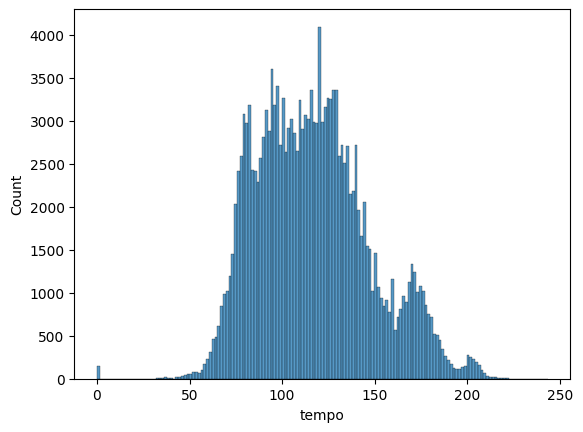

In [ ]:
sns.histplot(data=df_all, x='tempo')

In [ ]:
df_all['tempo'].skew()

0.44974061611034055

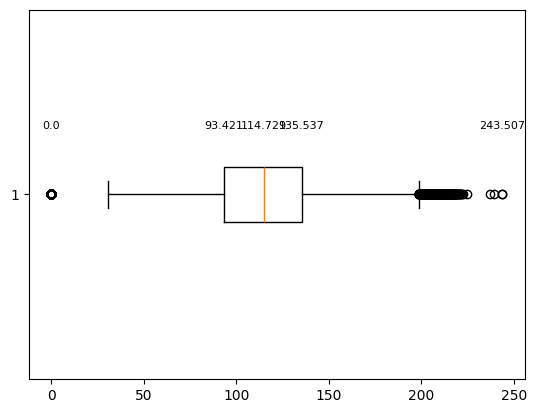

In [ ]:
fig, ax = plt.subplots(1)

ax.boxplot(data=df_all, x='tempo', vert=False)
box_data = df_all['tempo']
q1, q3 = box_data.quantile([0.25, 0.75])
median = box_data.median()
min_val = box_data.min()
max_val = box_data.max()

labels = [min_val, q1, median, q3, max_val]

for label in labels:
  plt.text(label,1.2,str(round(label,3)),fontsize=8,horizontalalignment='center',verticalalignment='top')

plt.show()

In [ ]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_all[(df_all['tempo'] < lower_bound) | (df_all['tempo'] > upper_bound)]
print(outliers.shape)
outliers['tempo'].describe()

(1645, 19)


count    1645.000000
mean      186.567376
std        57.745036
min         0.000000
25%       200.460000
50%       203.092000
75%       205.905000
max       243.507000
Name: tempo, dtype: float64

In [ ]:
outliers.loc[outliers['tempo'].idxmax()][['artists', 'name', 'tempo']]

artists                 [Bill Withers]
name       I Don't Want You on My Mind
tempo                          243.507
Name: 82884, dtype: object

In [ ]:
tempo_cutoff = df_all.loc[df_all['tempo'] > 160]
tempo_cutoff.loc[tempo_cutoff['tempo'].idxmin()][['artists', 'name', 'tempo']]

artists          [Gary Allan]
name       Watching Airplanes
tempo                 160.001
Name: 17118, dtype: object

In [ ]:
tempo_cutoff = df_all.loc[df_all['tempo'] > 200]
tempo_cutoff.loc[tempo_cutoff['tempo'].idxmin()][['artists', 'name', 'tempo']]

artists    [The Cab]
name             Bad
tempo        200.005
Name: 73311, dtype: object

Most popular songs today have a tempo of 100–140 beats per minute (BPM). However, the tempo of a song can vary depending on the genre:
- Jazz and funk: Typically 120–125 BPM
- Pop: Typically 100–130 BPM
- R&B: Typically 60–80 BPM
- Rock: Typically 110–140 BPM
- Dub: Typically 60–90 BPM
- Hip-hop: Typically 60–100 BPM
- House: Typically 115–130 BPM
- Techno/trance: Typically 120–140 BPM
- Dubstep: Typically 135–145 BPM
- Drum and bass: Typically 160–180 BPM

Some other musical terms related to tempo include:
- Allegro: Fast, quickly, and bright (109–132 BPM)
- Vivace: Lively and fast (132–140 BPM)
- Presto: Extremely fast (168–177 BPM)
- Prestissimo: Even faster than Presto (178 BPM and over)

The distribution plot shows 3 distinct peaks, so I listened to the songs from each of those peaks and noticed that a bpm of 200 (very high) sounds like it should be listed as 100bpm. After checking what the typical bpm values for songs from different genres are, it was clear that some true bpm values are double. So could the case be that fast songs are listed with slow tempos since the tempo could be halved. I will half all bpm values above 180 and see if the values are salvageable. I may have to ignore this variable, as there is no clear cutoff between songs that have their bpms doubled or not.

#### Genres

I'll show the distribution of genres in two different ways: song count per genre and genre by popularity

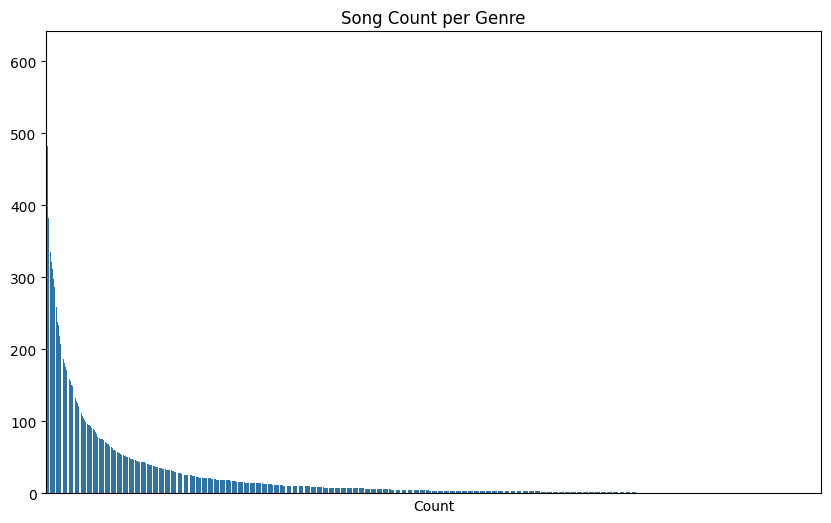

In [ ]:
df = df_w_genres.copy()
df_exploded = df.explode('genres')
df_exploded = df_exploded.dropna(subset=['genres'])
df_exploded.head()

plt.figure(figsize=(10, 6))
sns.countplot(x='genres', data=df_exploded, order=df_exploded['genres'].value_counts().index)
plt.title('Song Count per Genre')
plt.xlabel('Count')
plt.ylabel('')

# Remove x-axis labels (genre names)
plt.xticks([])

plt.show()

In [ ]:
# Get the top 10 genres by count
top_10_genres = df_exploded['genres'].value_counts().head(10)

# Display the top 10 genres
print("Top 10 Genres:")
print(top_10_genres)

# Get the bottom 10 genres by count
bottom_10_genres = df_exploded['genres'].value_counts().tail(10)

# Display the bottom 10 genres
print("Bottom 10 Genres:")
print(bottom_10_genres)

Top 10 Genres:
genres
rock                  611
pop                   593
dance pop             572
rap                   516
hip hop               507
pop rap               482
pop rock              400
modern rock           400
country rock          394
urban contemporary    383
Name: count, dtype: int64
Bottom 10 Genres:
genres
lldm                    1
tamaulipas rap          1
tuna estudiantil        1
italian gothic          1
italian gothic metal    1
italian metal           1
south african choral    1
bajki                   1
deep soul house         1
chinese indie rock      1
Name: count, dtype: int64


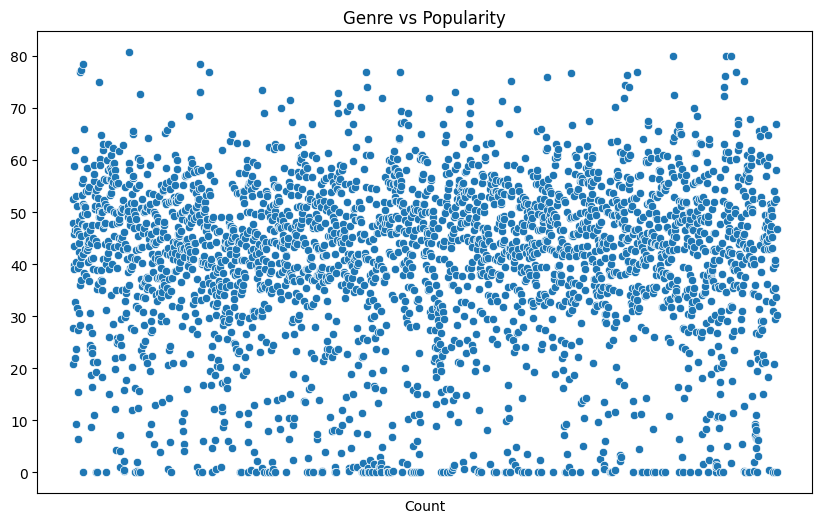

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_by_genres, x='genres', y='popularity')

plt.title('Genre vs Popularity')
plt.xlabel('Count')
plt.ylabel('')

plt.xticks([])

plt.show()

In [ ]:
sorted_genres = df_by_genres[['genres', 'popularity']].sort_values(by='popularity', ascending=False)
top_10_genres = sorted_genres.head(10)
bottom_10_genres = sorted_genres.tail(10)

print("Top 10 Genres by Popularity:")
print(top_10_genres)

print("Bottom 10 Genres by Popularity:")
print(bottom_10_genres)

Top 10 Genres by Popularity:
                   genres  popularity
237              basshall   80.666667
2778          turkish edm   80.000000
2533  south african house   80.000000
2755      trap venezolano   80.000000
46        alberta hip hop   78.500000
536    chinese electropop   78.500000
37              afroswing   77.312500
31              afro soul   77.000000
2383        russian dance   77.000000
1239             guaracha   77.000000
Bottom 10 Genres by Popularity:
                      genres  popularity
1426       israeli classical         0.0
1109                 full on         0.0
590       classic eurovision         0.0
829         deep psychobilly         0.0
2575               speedcore         0.0
2888     vintage spanish pop         0.0
828   deep progressive house         0.0
1428            israeli folk         0.0
2681               tajik pop         0.0
1723                medieval         0.0


The top 10 genres using song count per genre looks a lot more like I would expect compared to top 10 genres based on popularity. This could be because the popularity metric could be skewed by genres with very small sample sizes. The popularity metric is probably better for individual songs rather than the average popularity for a genre.

### Multivariate Analysis

We will begin by exploring the correlations between each of the potential variables. From the univariate analysis, we know we can ignore `duration_ms`, `liveness`, `speechiness`, and potentially `tempo`. Lets try to fix tempo according to our findings first before creating the correlation heatmap.

In [ ]:
df_all['tempo'] = df_all['tempo'].apply(lambda x: x/2 if x > 180 else x)

Now let's create that correlation heatmap

In [ ]:
df_all.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'speechiness',
       'tempo', 'num_artists'],
      dtype='object')

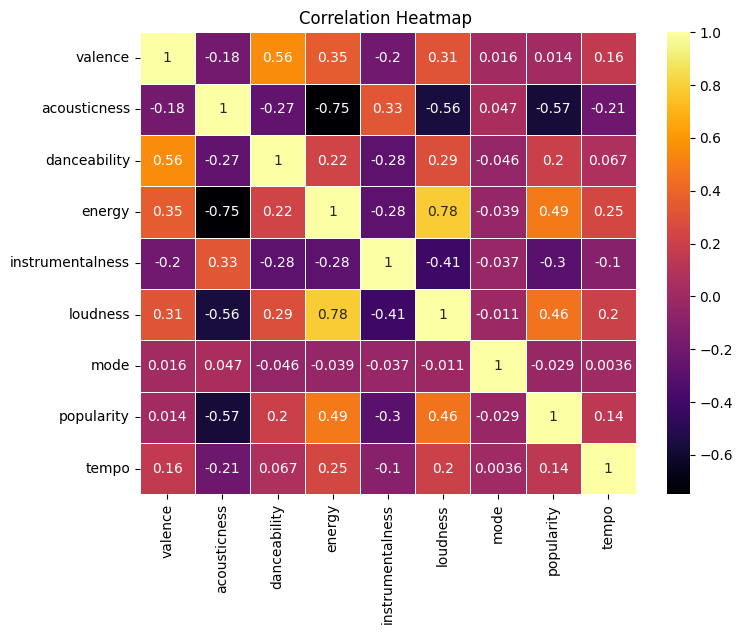

In [ ]:
selected_cols = ['valence', 'acousticness', 'danceability', 'energy',
                 'instrumentalness', 'loudness', 'mode', 'popularity', 'tempo']

correlation_matrix = df_all[selected_cols].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='inferno', linewidths=.5)
plt.title('Correlation Heatmap ')
plt.show()

<Figure size 1600x1600 with 0 Axes>

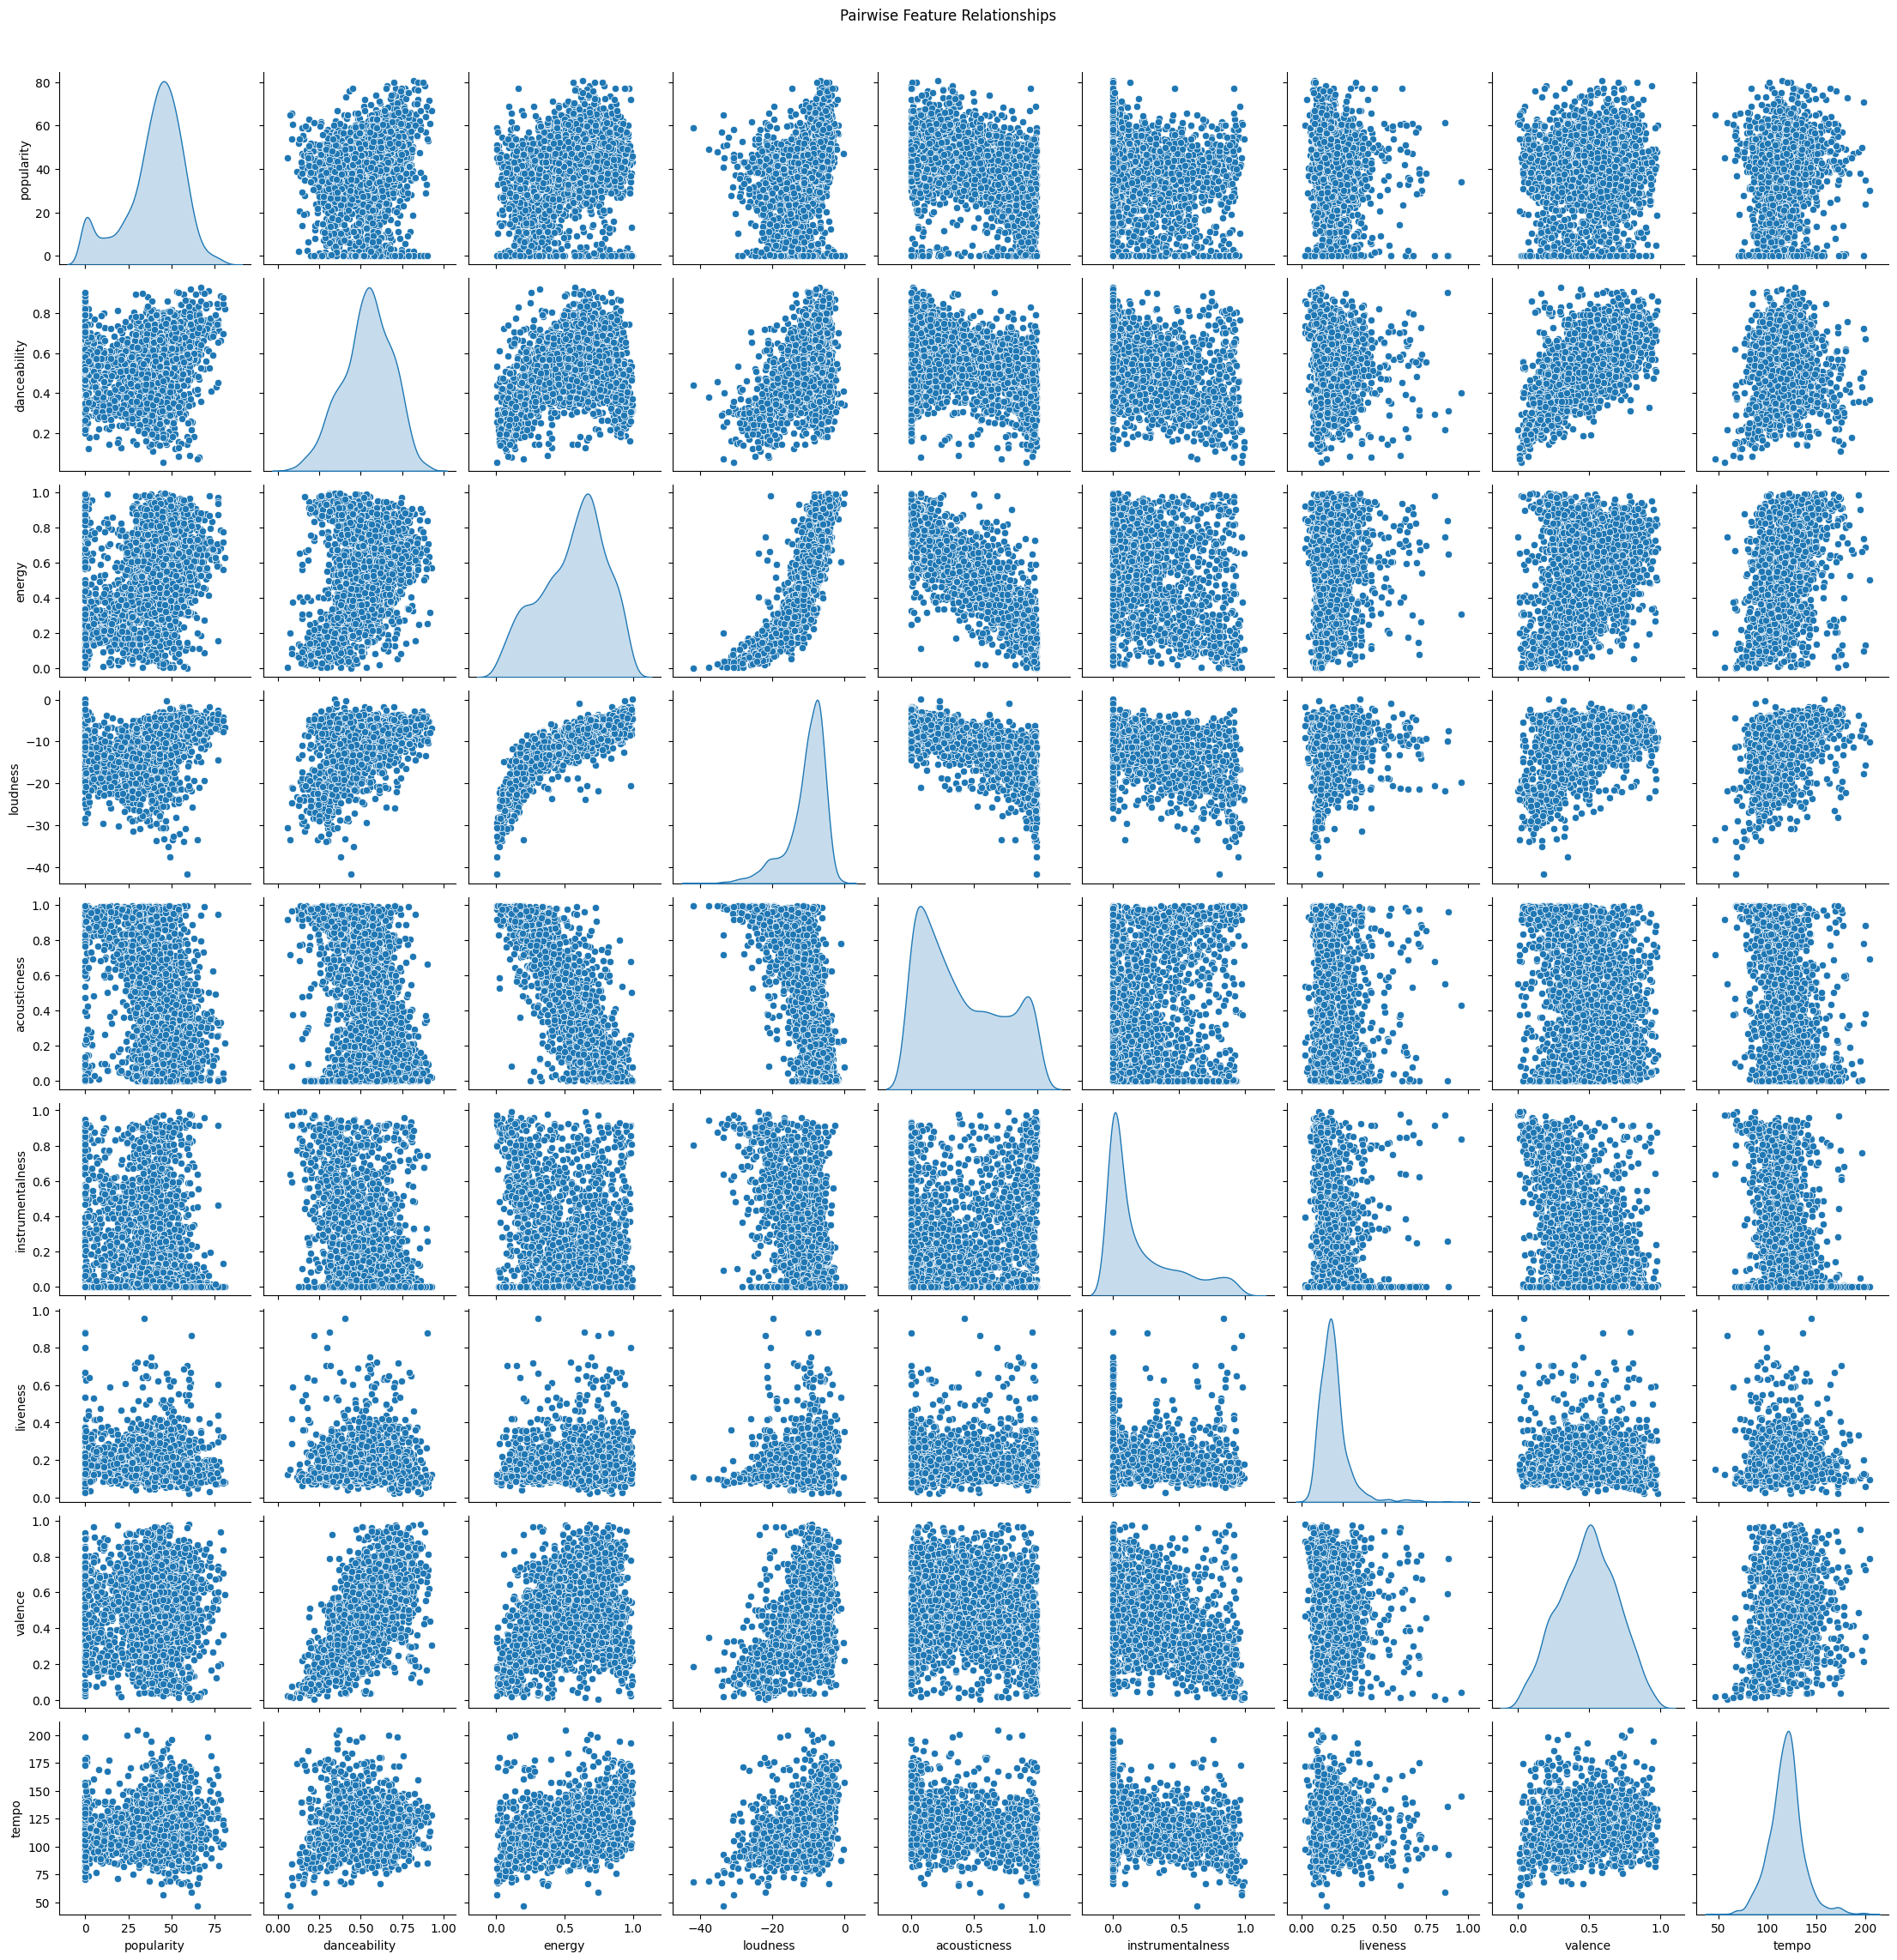

In [ ]:
features = ['popularity', 'danceability', 'energy', 'loudness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']

df_clean = df_by_genres.dropna(subset=features)
pairwise_plot = plt.figure(figsize=(16, 16))
sns.pairplot(df_clean[features], diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show(pairwise_plot)

In [ ]:
threshhold = 0.4
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
  for j in range(i+1, len(correlation_matrix.columns)):
    if abs(correlation_matrix.iloc[i, j]) > threshhold:
      high_corr_pairs.append((correlation_matrix.columns[i],
                              correlation_matrix.columns[j],
                              correlation_matrix.iloc[i, j]))

for pair in high_corr_pairs:
  print(f"{pair[0]} and {pair[1]}: {pair[2]}")

valence and danceability: 0.5589464770684084
acousticness and energy: -0.7493929916853719
acousticness and loudness: -0.5616963835982579
acousticness and popularity: -0.5731617749444469
energy and loudness: 0.7823619574329959
energy and popularity: 0.48500503965325725
instrumentalness and loudness: -0.4086112645072048
loudness and popularity: 0.45705061592166224


With these highly correlated features, we can potentially do some feature engineering and introduce new columns that combine the correlated features to account for interaction terms

### Implementing KNN Clustering

In [5]:
features = ['valence', 'acousticness', 'danceability', 'energy',
                 'instrumentalness', 'loudness', 'mode', 'popularity', 'tempo']

X = df_all[features]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [6]:
inertia = []
silhouette_scores = []
k_vals = range(5, 20)

In [9]:
df_genre = df_by_genres.copy()
df_genre = df_genre[df_genre['genres'] != '[]']

features = df_genre.drop(columns=['genres']).columns

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_genre[features])

# Iterate through range of n clusters
inertia_vals = []
silhouette_vals = []
n_clusters = range(2, 203, 5)

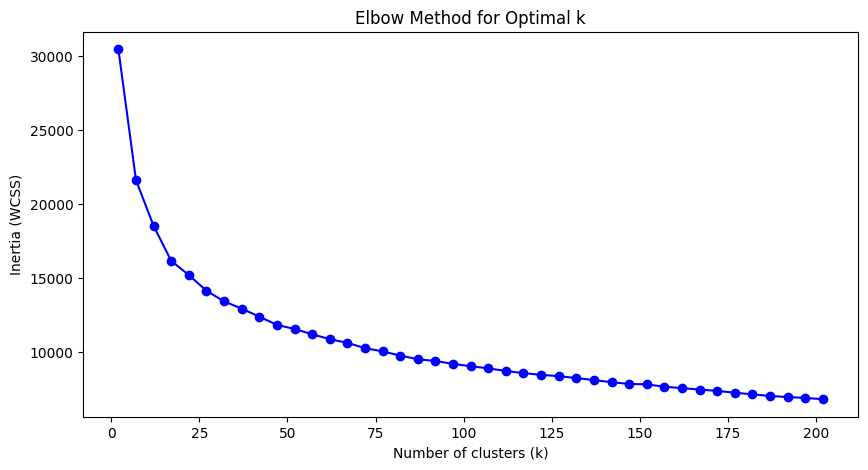

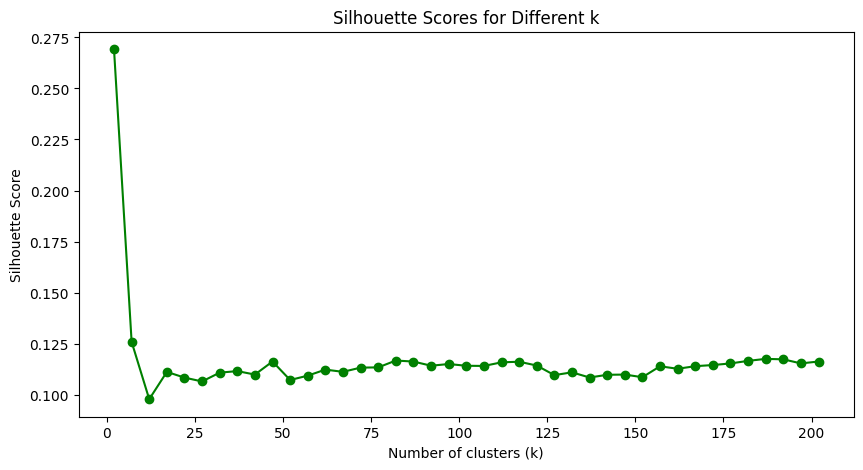

In [10]:
for n in n_clusters:
  kmeans = KMeans(n_clusters=n, random_state=20)
  cluster_labels = kmeans.fit_predict(X)

  # Calculate inertia
  inertia_vals.append(kmeans.inertia_)

  # Calculate silhouette score
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_vals.append(silhouette_avg)

# Plot Elbow Method Results
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, inertia_vals, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, silhouette_vals, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()



#### Principal Component Analysis (PCA)
PCA transforms a dataset with potentially many correlated features into a new set of uncorrelated features called principal components. These components capture the most important variations in the data.

* Principal Components: These are the new features created by PCA, each a linear combination of the original features. They are orthogonal to each other, ensuring no redundancy between them.
* Variance Explained: Each principal component captures a percentage of the total variance in the data. The first principal component (PC1) captures the most variance, the second (PC2) the next most, and so on.



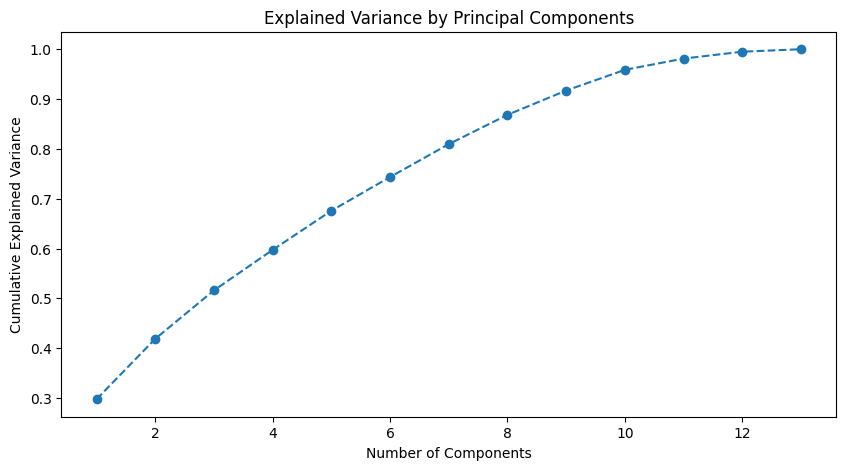

Number of components to retain 90% variance: 9


In [11]:
df_genre = df_by_genres.copy()
df_genre = df_genre[df_genre['genres'] != '[]']

features = df_genre.drop(columns=['genres']).columns

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_genre[features])

# Applying PCA
pca = PCA(n_components=None)  # Set to None to compute all components initially
X_pca = pca.fit_transform(X)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

# Step 4: Select the number of components
# For example, select components that explain at least 90% of the variance
n_components_90_variance = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print("Number of components to retain 90% variance:", n_components_90_variance)

# Step 5: Redo PCA with the selected number of components
pca = PCA(n_components=n_components_90_variance)
X_reduced = pca.fit_transform(X)



Now we can try to use K means again with to cluster genres using fewer dimensions.


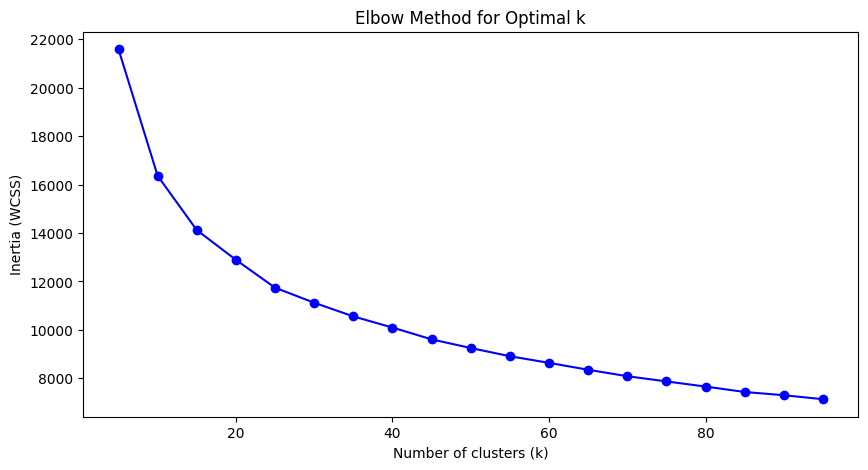

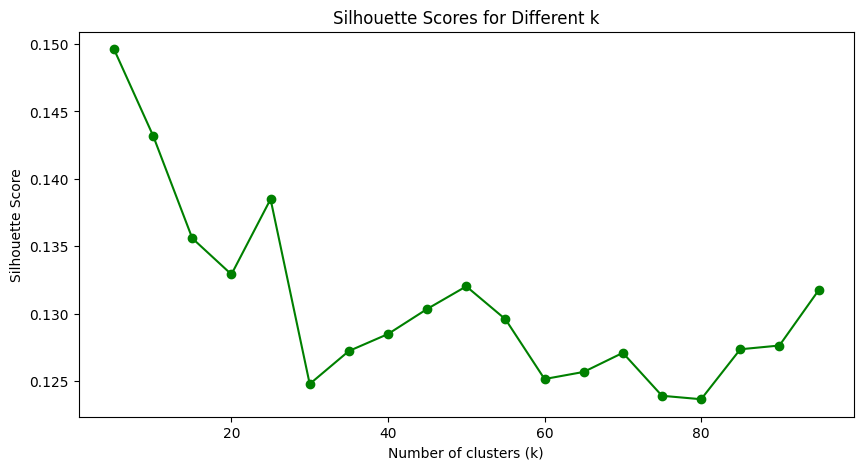

In [ ]:
# Iterate through range of n clusters
inertia_vals = []
silhouette_vals = []
n_clusters = range(5, 100, 5)
for n in n_clusters:
  kmeans = KMeans(n_clusters=n, random_state=20)
  cluster_labels = kmeans.fit_predict(X_reduced)

  # Calculate inertia
  inertia_vals.append(kmeans.inertia_)

  # Calculate silhouette score
  silhouette_avg = silhouette_score(X_reduced, cluster_labels)
  silhouette_vals.append(silhouette_avg)

# Plot Elbow Method Results
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, inertia_vals, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, silhouette_vals, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()


#### With Interaction Terms

In [12]:
features = ['valence', 'acousticness', 'danceability', 'energy',
                 'instrumentalness', 'loudness', 'mode', 'popularity', 'tempo']

X = df_all[features]
X = X.assign(valence_danceability=(X['valence'] * X['danceability']))
X = X.assign(acousticness_energy=(X['acousticness'] * X['energy']))
X = X.assign(acousticness_loudness=(X['acousticness'] * X['loudness']))
X = X.assign(acousticness_popularity=(X['acousticness'] * X['popularity']))
X = X.assign(energy_loudness=(X['energy'] * X['loudness']))
X = X.assign(energy_popularity=(X['energy'] * X['popularity']))
X = X.assign(instrumentalness_loudness=(X['instrumentalness'] * X['loudness']))
X = X.assign(loudness_popularity=(X['loudness'] * X['popularity']))

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [13]:
X_normalized

array([[0.0594    , 0.98594378, 0.28238866, ..., 0.01027314, 0.63169264,
        0.94477784],
       [0.963     , 0.73493976, 0.82894737, ..., 0.0207532 , 0.93406788,
        0.94952604],
       [0.0394    , 0.96485944, 0.33198381, ..., 0.01010273, 0.70171968,
        0.94637999],
       ...,
       [0.637     , 0.10140562, 0.6417004 , ..., 0.79370953, 0.93406756,
        0.92158612],
       [0.195     , 0.01002008, 0.6791498 , ..., 0.53081942, 0.93406696,
        0.83484598],
       [0.642     , 0.13253012, 0.86639676, ..., 0.64942305, 0.93367011,
        0.87052422]])

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import ast

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering

In [14]:
df_all_cols = np.array(df_all.columns)
df_w_genres_cols = np.array(df_w_genres.columns)
df_by_artist_cols = np.array(df_by_artist.columns)
df_by_year_cols = np.array(df_by_year.columns)
df_by_genres_cols = np.array(df_by_genres.columns)
similar_cols = np.intersect1d(df_w_genres_cols, df_by_genres_cols)
print(similar_cols)
unique_to_arr1 = np.setdiff1d(df_w_genres_cols, df_by_genres_cols)
print(unique_to_arr1)
unique_to_arr2 = np.setdiff1d(df_by_genres_cols, df_w_genres_cols)
print(unique_to_arr2)

['acousticness' 'danceability' 'duration_ms' 'energy' 'genres'
 'instrumentalness' 'key' 'liveness' 'loudness' 'mode' 'popularity'
 'speechiness' 'tempo' 'valence']
['artists' 'count']
[]


In [15]:
# Drop rows where there is no genre (Cant train and test with unlabeled data)
df = df_w_genres.copy()
df['genres'] = df['genres'].astype('string')
df = df[df['genres'] != '[]']
df['genres'] = df['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str)
    and x.startswith('[') else x)
df = df.reset_index(drop=True)

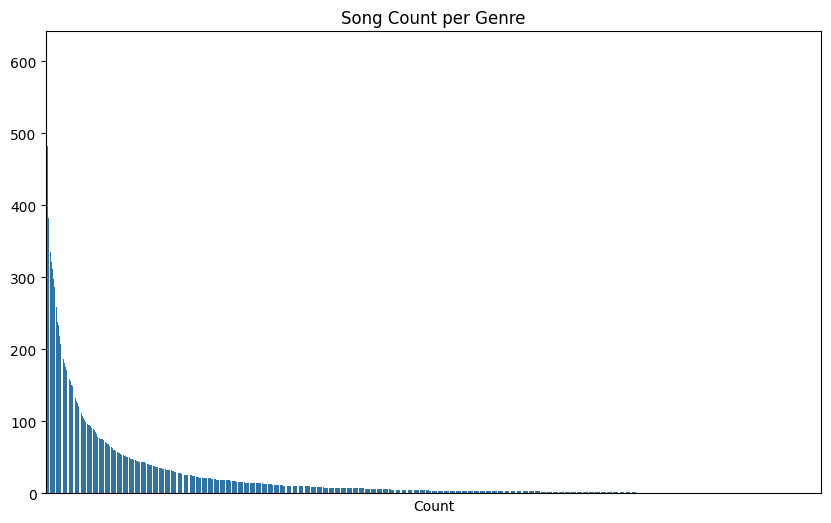

In [16]:
df_exploded = df.explode('genres')

plt.figure(figsize=(10, 6))
sns.countplot(x='genres', data=df_exploded, order=df_exploded['genres'].value_counts().index)
plt.title('Song Count per Genre')
plt.xlabel('Count')
plt.ylabel('')

# Remove x-axis labels (genre names)
plt.xticks([])

plt.show()

In [17]:
df_genre = df_by_genres.copy()
df_genre = df_genre[df_genre['genres'] != '[]']

features = df_genre.drop(columns=['genres']).columns

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df_genre[features])

# Iterate through range of n clusters
inertia_vals = []
silhouette_vals = []
n_clusters = range(2, 203, 5)

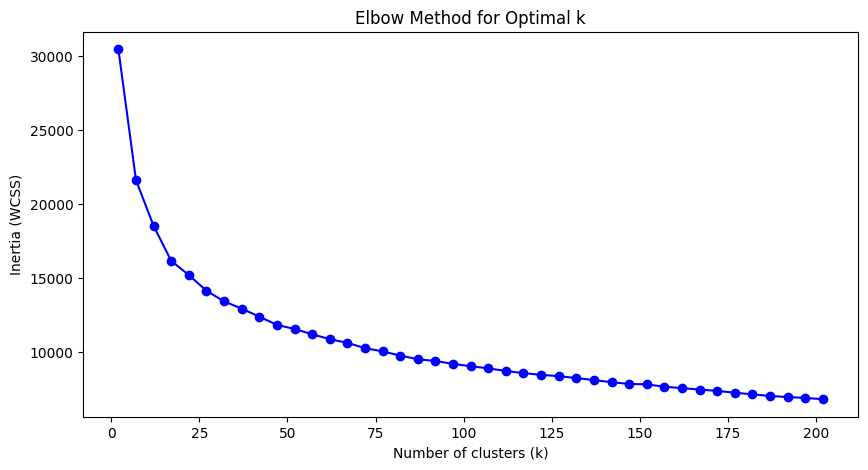

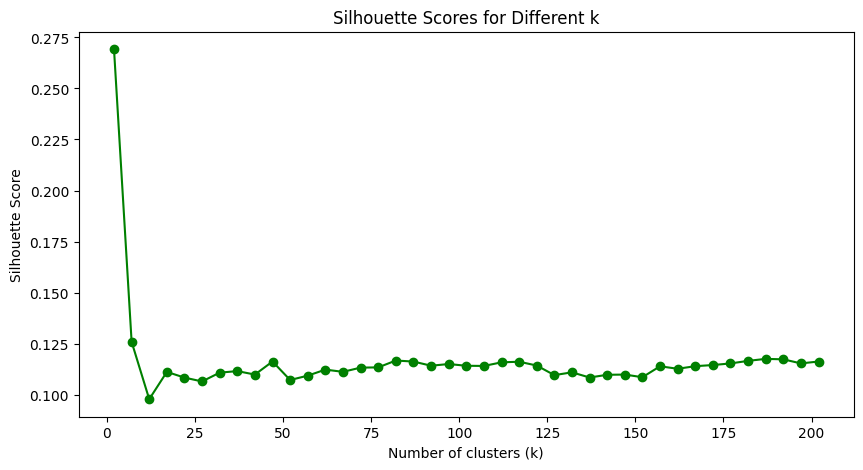

In [18]:
for n in n_clusters:
  kmeans = KMeans(n_clusters=n, random_state=20)
  cluster_labels = kmeans.fit_predict(X)

  # Calculate inertia
  inertia_vals.append(kmeans.inertia_)

  # Calculate silhouette score
  silhouette_avg = silhouette_score(X, cluster_labels)
  silhouette_vals.append(silhouette_avg)

# Plot Elbow Method Results
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, inertia_vals, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters, silhouette_vals, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()



Decision tree


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Optimal number of features: 1
Selected features: Index(['acousticness'], dtype='object')


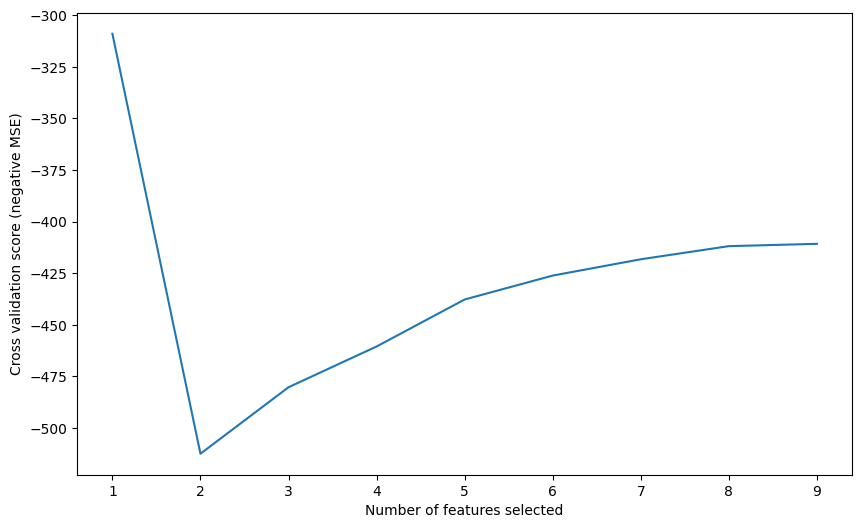

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
            'loudness', 'mode', 'speechiness', 'tempo']
target = 'popularity'

X = df_all[features]
y = df_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

tree_model = DecisionTreeRegressor(random_state=20)

rfecv = RFECV(estimator=tree_model, step=1, cv=StratifiedKFold(5), scoring='neg_mean_squared_error')

rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (negative MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [26]:
features = ['acousticness']
target = 'popularity'

X = df_all[features]
y = df_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

tree_model = DecisionTreeRegressor(random_state=20)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 306.67761750039017
R-squared: 0.35435505651545507


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Random Forest



In [27]:
from sklearn.ensemble import RandomForestRegressor

features = [ 'danceability', 'energy', 'loudness',  'speechiness' ]
target = 'popularity'

X = df_all[features]
y = df_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

model = RandomForestRegressor(n_estimators = 20, random_state=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 310.3773710150915
R-squared: 0.34656600699702045


In [28]:

features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
            'loudness', 'mode', 'speechiness', 'tempo']

X = df_all[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=20)
kmeans.fit(X_scaled)

df_all['cluster'] = kmeans.labels_

cluster_popularity = df_all.groupby('cluster')['popularity'].mean()

print(cluster_popularity)

cluster
0    44.330340
1    23.610372
2    15.398902
3    38.486408
4     5.160993
Name: popularity, dtype: float64


In [29]:
features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
            'loudness', 'mode', 'speechiness', 'tempo']
target = 'popularity'

X = df_all[features]
y = df_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kmeans = KMeans(n_clusters=5, random_state=20)
kmeans.fit(X_train_scaled)

X_train['cluster'] = kmeans.labels_
X_test['cluster'] = kmeans.predict(X_test_scaled)

# Create a temporary DataFrame to merge cluster labels with popularity
train_with_clusters = pd.concat([X_train, y_train], axis=1)

# Calculate cluster popularity using the temporary DataFrame
cluster_popularity = train_with_clusters.groupby('cluster')[target].mean()

y_pred = X_test['cluster'].map(cluster_popularity)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 341.2171232213619
R-squared: 0.28163942307287915


## Training an SVM model to find predict song genre
### Creating training and testing data



In [ ]:
df = df_w_genres.copy()
df['genres'] = df['genres'].astype('string')
df = df[df['genres'] != '[]']
df['genres'] = df['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str)
    and x.startswith('[') else x)
df = df.reset_index(drop=True)

# Verify that genres in df_w_genres are the same as in the
# df with genre avg characteristics
unique_genres = set(
    genre for genres_list in df['genres']
    if isinstance(genres_list, list)
    for genre in genres_list)

df_genre = df_by_genres.copy()
genres = df_genre['genres'].unique()
genres = set(genres)

difference = unique_genres.symmetric_difference(genres)

# print("Genres that are different:", difference)

df_genre = df_genre[df_genre['genres'] != '[]']

# Check which columns are different between dfs
similar_cols = np.intersect1d(df.columns, df_genre.columns)
print(similar_cols)
unique_to_arr1 = np.setdiff1d(df.columns, df_genre.columns)
print(unique_to_arr1)
unique_to_arr2 = np.setdiff1d(df_genre.columns, df.columns)
print(unique_to_arr2)




['acousticness' 'danceability' 'duration_ms' 'energy' 'genres'
 'instrumentalness' 'key' 'liveness' 'loudness' 'mode' 'popularity'
 'speechiness' 'tempo' 'valence']
['artists' 'count']
[]


In [ ]:
Xtr, Xts, ytr, yts = train_test_split(df, df['genres'], test_size=0.2, random_state=20)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

In [ ]:
df = df_w_genres.copy()
df['genres'] = df['genres'].astype('string')
df = df[df['genres'] != '[]']
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df = df.reset_index(drop=True)


all_genres = [genre for sublist in df['genres'] for genre in sublist]
top_genres = [genre for genre, count in Counter(all_genres).most_common(25)]


df['genres'] = df['genres'].apply(lambda x: [genre for genre in x if genre in top_genres])
df = df[df['genres'].apply(len) > 0]

Xtr, Xts, ytr, yts = train_test_split(df, df['genres'], test_size=0.2, random_state=42)

mlb = MultiLabelBinarizer(classes=top_genres)
ytr_bin = mlb.fit_transform(ytr)
yts_bin = mlb.transform(yts)

features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
            'loudness', 'mode', 'speechiness', 'tempo']

Xtr_features = Xtr[features]
Xts_features = Xts[features]

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneVsRestClassifier(LinearSVC(random_state=20)))
])

svm_pipeline.fit(Xtr_features, ytr_bin)

y_pred = svm_pipeline.predict(Xts_features)

accuracy = accuracy_score(yts_bin, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(yts_bin, y_pred, target_names=top_genres)
print(report)

Accuracy: 0.02476780185758514
                    precision    recall  f1-score   support

              rock       0.73      0.07      0.12       120
               pop       0.00      0.00      0.00       106
         dance pop       0.00      0.00      0.00       104
               rap       0.27      0.03      0.06       117
           hip hop       0.63      0.18      0.28       104
           pop rap       0.00      0.00      0.00        90
       modern rock       0.00      0.00      0.00        71
          pop rock       0.00      0.00      0.00        69
      country rock       0.00      0.00      0.00        58
urban contemporary       0.00      0.00      0.00        63
         folk rock       0.00      0.00      0.00        87
             latin       0.00      0.00      0.00        80
         soft rock       0.00      0.00      0.00        77
              trap       0.50      0.01      0.02        80
       mellow gold       0.00      0.00      0.00        69
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  @validate_params(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  @validate_params(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  @validate_params(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  @validate_params(


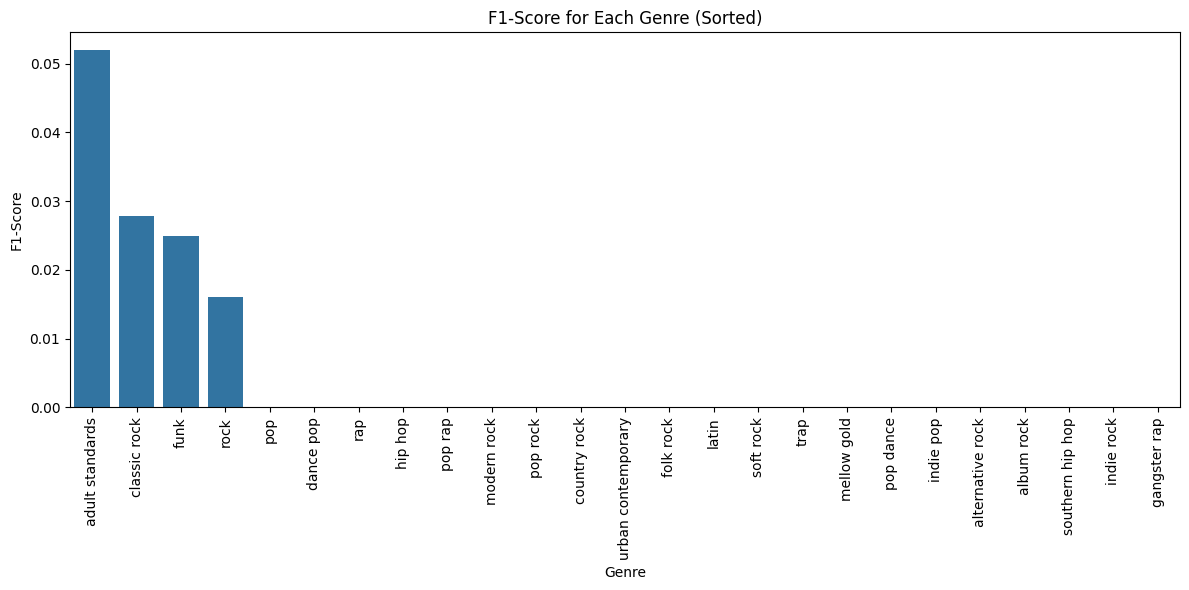

In [ ]:
report = classification_report(yts_bin, y_pred_bin, target_names=mlb.classes_, output_dict=True)

# Extract f1-score for each label
f1_scores = {label: data['f1-score'] for label, data in report.items() if label in mlb.classes_}

# Sort labels by f1-score in descending order
sorted_labels = sorted(f1_scores, key=f1_scores.get, reverse=True)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_labels, y=[f1_scores[label] for label in sorted_labels])
plt.xticks(rotation=90)
plt.title('F1-Score for Each Genre (Sorted)')
plt.xlabel('Genre')
plt.ylabel('F1-Score')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  @validate_params(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  @validate_params(


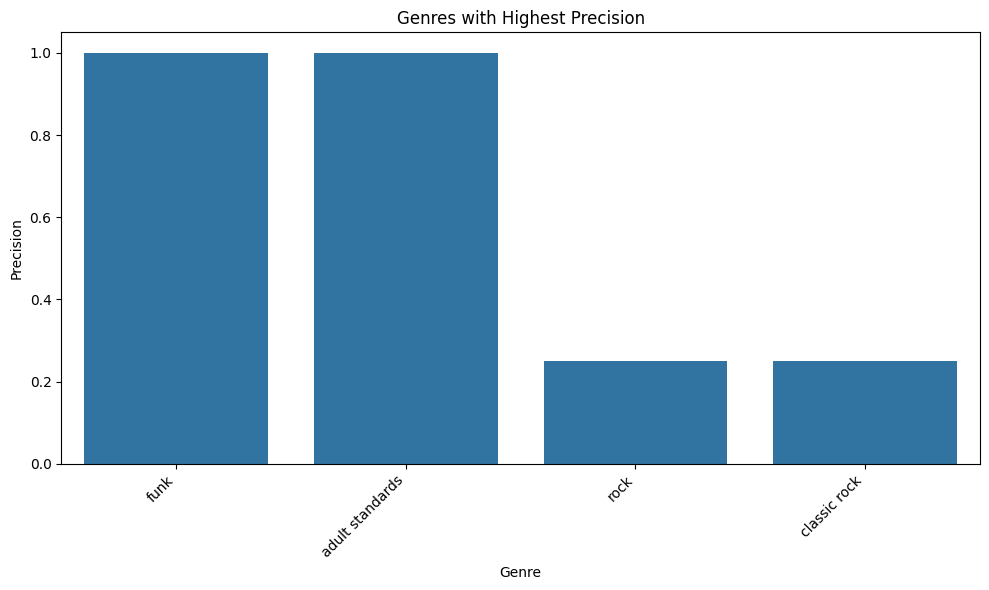

In [ ]:
report = classification_report(yts_bin, y_pred_bin, target_names=mlb.classes_, output_dict=True)

precision_scores = {label: data['precision'] for label, data in report.items() if label in mlb.classes_}

sorted_labels = sorted(precision_scores, key=precision_scores.get, reverse=True)

top_genres = sorted_labels[:4]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres, y=[precision_scores[label] for label in top_genres])
plt.xticks(rotation=45, ha='right')
plt.title('Genres with Highest Precision')
plt.xlabel('Genre')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()